In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime


In [3]:
with open('./datasets/business_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_businesses = pd.read_json(data_json_str)
    df_businesses['business_id'] = 'biz_' + df_businesses['business_id']
    
with open('./datasets/user_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_users = pd.read_json(data_json_str)
    
with open('./datasets/review_dataset_new_orleans.json', 'r') as f:
    data = f.readlines()
    data = list(map(lambda x: x.rstrip(), data))
    data_json_str = "[" + ','.join(data) + "]"
    df_reviews = pd.read_json(data_json_str)
    df_reviews['review_id'] = 'rev_' + df_reviews['review_id']
    df_reviews['business_id'] = 'biz_' + df_reviews['business_id']

# convert friends to list
df_users['friends'] = df_users['friends'].apply(lambda x: x.split(','))
# convert elite to list
df_users['elite'] = df_users['elite'].apply(lambda x: x.split(','))

C:\Users\maysa\AppData\Local\Temp\ipykernel_7512\4277523074.py:5: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_businesses = pd.read_json(data_json_str)
C:\Users\maysa\AppData\Local\Temp\ipykernel_7512\4277523074.py:12: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_users = pd.read_json(data_json_str)
C:\Users\maysa\AppData\Local\Temp\ipykernel_7512\4277523074.py:18: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_reviews = pd.read_json(data_json_str)


In [4]:
user_ids_set = set(df_users['user_id'])

def remove_non_existing_friends(friends):
    return list(set(friends) & user_ids_set)

print("Before removing non-existing friends:", df_users['friends'].apply(len).sum())

df_users['friends'] = df_users['friends'].apply(remove_non_existing_friends)

print("After removing non-existing friends:", df_users['friends'].apply(len).sum())
print("------------------------------------")
print("Before removing users with no friends:", len(df_users))

df_users = df_users[df_users['friends'].apply(len) > 0]

print("After removing users with no friends:", len(df_users))


Before removing non-existing friends: 18945313
After removing non-existing friends: 14555
------------------------------------
Before removing users with no friends: 245354
After removing users with no friends: 14555


In [5]:
print("Before removing reviews with non-existant users: ", len(df_reviews))

# remove review if user is not in the graph
df_reviews = df_reviews[df_reviews['user_id'].isin(df_users['user_id'])]

print("After removing: ", len(df_reviews))

print("------------------------------------")

print("Before removing users with less than 2 reviews: ", len(df_users))

# remove user if they have less than 2 reviews
df_users = df_users[df_users['review_count'] >= 2]

print("After removing: ", len(df_users))

print("------------------------------------")

print("Before removing reviews of non-existant businesses: ", len(df_reviews))

# remove review if business is not in the graph
df_reviews = df_reviews[df_reviews['business_id'].isin(df_businesses['business_id'])]

print("After removing: ", len(df_reviews))

Before removing reviews with non-existant users:  635364
After removing:  90306
------------------------------------
Before removing users with less than 2 reviews:  14555
After removing:  13769
------------------------------------
Before removing reviews of non-existant businesses:  90306
After removing:  90306


In [6]:
print("Before removing businesses with no reviews: ", len(df_businesses))

# remove business if they have less than 2 reviews
df_businesses = df_businesses[df_businesses['review_count'] >= 1]

print("After removing: ", len(df_businesses))

print("------------------------------------")

print("Before bussinesses that are not opened: ", len(df_businesses))

# remove businesses that are not opened
df_businesses = df_businesses[df_businesses['is_open'] == 1]

print("After removing: ", len(df_businesses))

Before removing businesses with no reviews:  6209
After removing:  6209
------------------------------------
Before bussinesses that are not opened:  6209
After removing:  4649


13769
Number of nodes:  13769


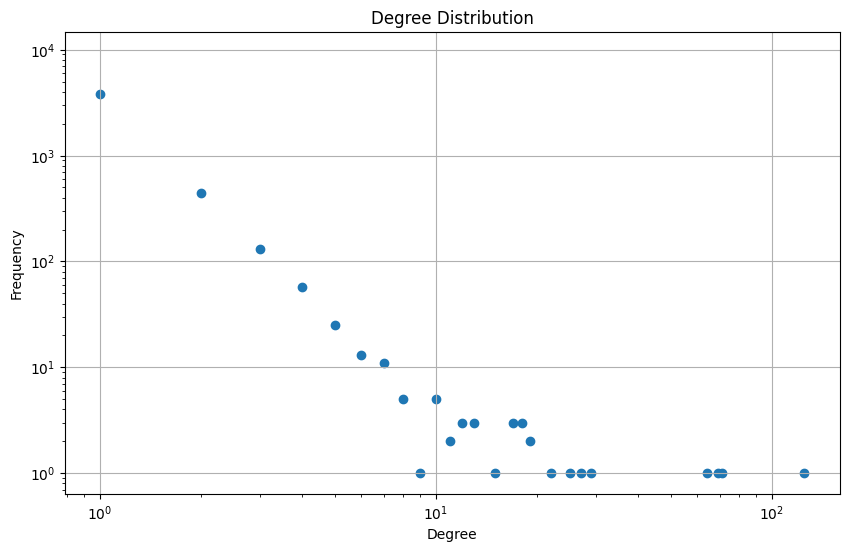

Nodes and edges: 13769 3179


In [7]:
network = nx.Graph()

print(len(df_users['user_id']))

network.add_nodes_from(df_users['user_id'])



for user,friends in zip(df_users['user_id'], df_users['friends']):
    for friend in friends:
        if friend in df_users['user_id'].values:
            network.add_edge(user, friend)

print("Number of nodes: ", network.number_of_nodes())
# sorted list with degree of each node
degree_sequence = sorted([d for n, d in network.degree()], reverse=True)

degree_freq = {}
for degree in degree_sequence:
    if degree in degree_freq:
        degree_freq[degree] += 1
    else:
        degree_freq[degree] = 1


# create degree distribution plot, not histogram
plt.figure(figsize=(10, 6))
plt.scatter(degree_freq.keys(), degree_freq.values())
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.grid(True)
plt.title('Degree Distribution')
plt.show()

print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

In [8]:
# len of list where degree is better than 10
topX = len([d for n, d in network.degree() if d > 10])
print(topX)

# remove isolated
network.remove_nodes_from(list(nx.isolates(network)))

25


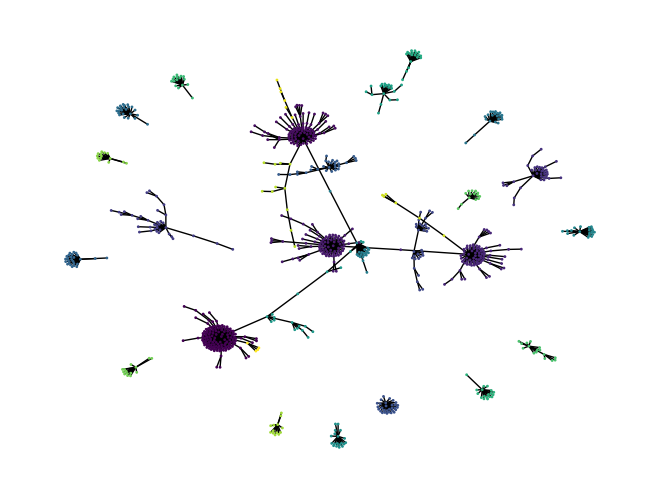

In [9]:
# Subgraph induced by node with higher degree
max_degree_node = sorted(dict(network.degree()).items(), key=lambda x: x[1], reverse=True)[:topX]
max_degree_node_ids = [node[0] for node in max_degree_node]
subgraph_nodes = set()

for node in max_degree_node_ids:
    subgraph_nodes |= set(nx.node_connected_component(network, node))

g_sub = network.subgraph(subgraph_nodes)

# Communities 
communities = nx.community.greedy_modularity_communities(g_sub)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in g_sub.nodes()]

pos = nx.spring_layout(g_sub)
nx.draw(g_sub, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()


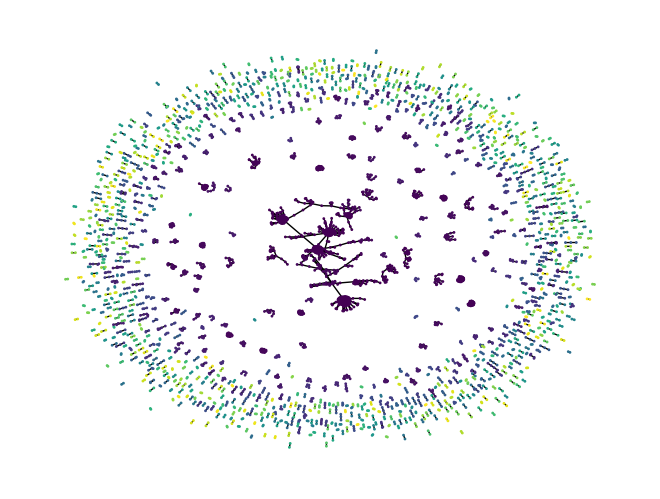

In [10]:
# find communities in main graph
communities = nx.community.greedy_modularity_communities(network)

node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Color nodes by community
colors = [node_to_community[node] for node in network.nodes()]

pos = nx.spring_layout(network)
nx.draw(network, pos, node_color=colors, node_size=1, with_labels=False)
plt.show()

In [11]:
# print number of nodes, edges 
print("Nodes and edges:", network.number_of_nodes(), network.number_of_edges())

Nodes and edges: 4500 3179


In [12]:
betwenness = nx.betweenness_centrality(network)

sorted_betweenness = sorted(betwenness.items(), key=lambda x: x[1], reverse=True)

elite_users = list(df_users[df_users['elite'].apply(len) > 0]['user_id'])

top_percent = 10
top_nodes = sorted_betweenness[:int(len(sorted_betweenness) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by betweenness centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by betweenness centrality: 100.0%


In [13]:
degree = nx.degree_centrality(network)

sorted_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_degree[:int(len(sorted_degree) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by degree centrality: {percentage_elite}%")

Percentage of elite users in top 10% of users by degree centrality: 100.0%


In [14]:
page_rank = nx.pagerank(network)

sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)

top_nodes = sorted_page_rank[:int(len(sorted_page_rank) * top_percent / 100)]
elite_users_in_top = sum(1 for node in top_nodes if node[0] in elite_users)
percentage_elite = elite_users_in_top / len(top_nodes) * 100

print(f"Percentage of elite users in top {top_percent}% of users by page rank: {percentage_elite}%")

Percentage of elite users in top 10% of users by page rank: 100.0%


In [15]:
# total num of reviews for elite and non-elite users
elite_users_reviews = df_reviews[df_reviews['user_id'].isin(elite_users)]
non_elite_users_reviews = df_reviews[~df_reviews['user_id'].isin(elite_users)]

elite_users_reviews_count = len(elite_users_reviews)
non_elite_users_reviews_count = len(non_elite_users_reviews)

print(f"Total number of reviews by elite users: {elite_users_reviews_count}")
print(f"Total number of reviews by non-elite users: {non_elite_users_reviews_count}")

Total number of reviews by elite users: 89516
Total number of reviews by non-elite users: 790
